In [3]:
# Let's make this notebook compatible for Python 2 and 3
from __future__ import division, print_function

# Import libraries
import pandas as pd
import numpy as np
import os
import math
import copy

# for visualization
import matplotlib.pyplot as plt

# to import module from parent directory
import sys
sys.path.append('..')

# Dataset API from sklearn
from sklearn import datasets

In [26]:
# Import helper functions
from utils import Plot, accuracy_score, train_test_split
from utils import to_categorical, normalize

from deep_learning.neural_network import NeuralNetwork
from deep_learning.layers import Activation, Dense
from deep_learning.optimizers import Adam
from deep_learning.loss_functions import CrossEntropy

In [27]:
class Neuroevolution():
    """ Evolutionary optimization of Neural Networks.

    Parameters:
    -----------
    n_individuals: int
        The number of neural networks that are allowed in the population at a time.
    mutation_rate: float
        The probability that a weight will be mutated.
    model_builder: method
        A method which returns a user specified NeuralNetwork instance. 
    """
    def __init__(self, population_size, mutation_rate, model_builder):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_builder = model_builder

    def _build_model(self, id):
        """ Returns a new individual """
        model = self.model_builder(n_inputs=self.X.shape[1], n_outputs=self.y.shape[1])
        model.id = id
        model.fitness = 0
        model.accuracy = 0
        
        return model

    def _initialize_population(self):
        """ Initialization of the neural networks forming the population"""
        self.population = []
        for _ in range(self.population_size):
            model = self._build_model(id=np.random.randint(1000))
            self.population.append(model)

    def _mutate(self, individual, var=1):
        """ Add zero mean gaussian noise to the layer weights with probability mutation_rate """
        for layer in individual.layers:
            if hasattr(layer, 'W'):
                # Mutation of weight with probability self.mutation_rate
                mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=layer.W.shape)
                layer.W += np.random.normal(loc=0, scale=var, size=layer.W.shape) * mutation_mask
                mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=layer.w0.shape)
                layer.w0 += np.random.normal(loc=0, scale=var, size=layer.w0.shape) * mutation_mask
        
        return individual

    def _inherit_weights(self, child, parent):
        """ Copies the weights from parent to child """
        for i in range(len(child.layers)):
            if hasattr(child.layers[i], 'W'):
                # The child inherits both weights W and bias weights w0
                child.layers[i].W = parent.layers[i].W.copy()
                child.layers[i].w0 = parent.layers[i].w0.copy()

    def _crossover(self, parent1, parent2):
        """ Performs crossover between the neurons in parent1 and parent2 to form offspring """
        child1 = self._build_model(id=parent1.id+1)
        self._inherit_weights(child1, parent1)
        child2 = self._build_model(id=parent2.id+1)
        self._inherit_weights(child2, parent2)

        # Perform crossover
        for i in range(len(child1.layers)):
            if hasattr(child1.layers[i], 'W'):
                n_neurons = child1.layers[i].W.shape[1]
                # Perform crossover between the individuals' neuron weights
                cutoff = np.random.randint(0, n_neurons)
                child1.layers[i].W[:, cutoff:] = parent2.layers[i].W[:, cutoff:].copy()
                child1.layers[i].w0[:, cutoff:] = parent2.layers[i].w0[:, cutoff:].copy()
                child2.layers[i].W[:, cutoff:] = parent1.layers[i].W[:, cutoff:].copy()
                child2.layers[i].w0[:, cutoff:] = parent1.layers[i].w0[:, cutoff:].copy()
        
        return child1, child2

    def _calculate_fitness(self):
        """ Evaluate the NNs on the test set to get fitness scores """
        for individual in self.population:
            loss, acc = individual.test_on_batch(self.X, self.y)
            individual.fitness = 1 / (loss + 1e-8)
            individual.accuracy = acc

    def evolve(self, X, y, n_generations):
        """ Will evolve the population for n_generations based on dataset X and labels y"""
        self.X, self.y = X, y

        self._initialize_population()

        # The 40% highest fittest individuals will be selected for the next generation
        n_winners = int(self.population_size * 0.4)
        # The fittest 60% of the population will be selected as parents to form offspring
        n_parents = self.population_size - n_winners

        for epoch in range(n_generations):
            # Determine the fitness of the individuals in the population
            self._calculate_fitness()

            # Sort population by fitness
            sorted_i = np.argsort([model.fitness for model in self.population])[::-1]
            self.population = [self.population[i] for i in sorted_i]

            # Get the individual with the highest fitness
            fittest_individual = self.population[0]
            print ("[%d Best Individual - Fitness: %.5f, Accuracy: %.1f%%]" % (epoch, 
                                                                        fittest_individual.fitness, 
                                                                        float(100*fittest_individual.accuracy)))
            # The 'winners' are selected for the next generation
            next_population = [self.population[i] for i in range(n_winners)]

            total_fitness = np.sum([model.fitness for model in self.population])
            # The probability that a individual will be selected as a parent is proportionate to its fitness
            parent_probabilities = [model.fitness / total_fitness for model in self.population]
            # Select parents according to probabilities (without replacement to preserve diversity)
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                # Perform crossover to produce offspring
                child1, child2 = self._crossover(parents[i], parents[i+1])
                # Save mutated offspring for next population
                next_population += [self._mutate(child1), self._mutate(child2)]

            self.population = next_population

        return fittest_individual



+---------------+
| Model Summary |
+---------------+
Input Shape: (64,)
+----------------------+------------+--------------+
| Layer Type           | Parameters | Output Shape |
+----------------------+------------+--------------+
| Dense                | 1040       | (16,)        |
| Activation (ReLU)    | 0          | (16,)        |
| Dense                | 170        | (10,)        |
| Activation (Softmax) | 0          | (10,)        |
+----------------------+------------+--------------+
Total Parameters: 1210

Population Size: 100
Generations: 3000
Mutation Rate: 0.01

[0 Best Individual - Fitness: 3.08301, Accuracy: 10.5%]
[1 Best Individual - Fitness: 3.08746, Accuracy: 12.0%]
[2 Best Individual - Fitness: 3.08967, Accuracy: 19.6%]
[3 Best Individual - Fitness: 3.11408, Accuracy: 16.2%]
[4 Best Individual - Fitness: 3.11408, Accuracy: 16.2%]
[5 Best Individual - Fitness: 3.11408, Accuracy: 16.2%]
[6 Best Individual - Fitness: 3.13622, Accuracy: 17.2%]
[7 Best Individual - Fitne

[135 Best Individual - Fitness: 4.50788, Accuracy: 58.2%]
[136 Best Individual - Fitness: 4.50788, Accuracy: 58.2%]
[137 Best Individual - Fitness: 4.50788, Accuracy: 58.2%]
[138 Best Individual - Fitness: 4.50788, Accuracy: 58.2%]
[139 Best Individual - Fitness: 4.50788, Accuracy: 58.2%]
[140 Best Individual - Fitness: 4.50788, Accuracy: 58.2%]
[141 Best Individual - Fitness: 4.50788, Accuracy: 58.2%]
[142 Best Individual - Fitness: 4.53855, Accuracy: 50.0%]
[143 Best Individual - Fitness: 4.53855, Accuracy: 50.0%]
[144 Best Individual - Fitness: 4.53855, Accuracy: 50.0%]
[145 Best Individual - Fitness: 4.53898, Accuracy: 55.7%]
[146 Best Individual - Fitness: 4.55703, Accuracy: 54.6%]
[147 Best Individual - Fitness: 4.62908, Accuracy: 51.3%]
[148 Best Individual - Fitness: 4.62908, Accuracy: 51.3%]
[149 Best Individual - Fitness: 4.63142, Accuracy: 51.0%]
[150 Best Individual - Fitness: 4.63666, Accuracy: 50.5%]
[151 Best Individual - Fitness: 4.63666, Accuracy: 50.5%]
[152 Best Indi

[277 Best Individual - Fitness: 8.25099, Accuracy: 77.8%]
[278 Best Individual - Fitness: 8.25099, Accuracy: 77.8%]
[279 Best Individual - Fitness: 8.34167, Accuracy: 78.7%]
[280 Best Individual - Fitness: 8.34167, Accuracy: 78.7%]
[281 Best Individual - Fitness: 8.34167, Accuracy: 78.7%]
[282 Best Individual - Fitness: 8.34167, Accuracy: 78.7%]
[283 Best Individual - Fitness: 8.54540, Accuracy: 80.0%]
[284 Best Individual - Fitness: 8.54540, Accuracy: 80.0%]
[285 Best Individual - Fitness: 8.54540, Accuracy: 80.0%]
[286 Best Individual - Fitness: 8.68136, Accuracy: 80.4%]
[287 Best Individual - Fitness: 8.68136, Accuracy: 80.4%]
[288 Best Individual - Fitness: 8.68136, Accuracy: 80.4%]
[289 Best Individual - Fitness: 8.83897, Accuracy: 78.9%]
[290 Best Individual - Fitness: 8.83897, Accuracy: 78.9%]
[291 Best Individual - Fitness: 8.83897, Accuracy: 78.9%]
[292 Best Individual - Fitness: 8.83897, Accuracy: 78.9%]
[293 Best Individual - Fitness: 8.83897, Accuracy: 78.9%]
[294 Best Indi

[417 Best Individual - Fitness: 13.31400, Accuracy: 86.3%]
[418 Best Individual - Fitness: 13.31400, Accuracy: 86.3%]
[419 Best Individual - Fitness: 13.50454, Accuracy: 87.6%]
[420 Best Individual - Fitness: 13.50454, Accuracy: 87.6%]
[421 Best Individual - Fitness: 13.50454, Accuracy: 87.6%]
[422 Best Individual - Fitness: 13.50454, Accuracy: 87.6%]
[423 Best Individual - Fitness: 13.50454, Accuracy: 87.6%]
[424 Best Individual - Fitness: 13.50454, Accuracy: 87.6%]
[425 Best Individual - Fitness: 13.50454, Accuracy: 87.6%]
[426 Best Individual - Fitness: 13.50454, Accuracy: 87.6%]
[427 Best Individual - Fitness: 13.74511, Accuracy: 88.0%]
[428 Best Individual - Fitness: 13.74511, Accuracy: 88.0%]
[429 Best Individual - Fitness: 13.74511, Accuracy: 88.0%]
[430 Best Individual - Fitness: 13.74511, Accuracy: 88.0%]
[431 Best Individual - Fitness: 13.74511, Accuracy: 88.0%]
[432 Best Individual - Fitness: 13.74511, Accuracy: 88.0%]
[433 Best Individual - Fitness: 13.74511, Accuracy: 88.0

[557 Best Individual - Fitness: 19.40457, Accuracy: 91.2%]
[558 Best Individual - Fitness: 19.40457, Accuracy: 91.2%]
[559 Best Individual - Fitness: 19.40457, Accuracy: 91.2%]
[560 Best Individual - Fitness: 19.40457, Accuracy: 91.2%]
[561 Best Individual - Fitness: 19.41409, Accuracy: 91.6%]
[562 Best Individual - Fitness: 19.41409, Accuracy: 91.6%]
[563 Best Individual - Fitness: 19.41409, Accuracy: 91.6%]
[564 Best Individual - Fitness: 19.41409, Accuracy: 91.6%]
[565 Best Individual - Fitness: 19.41409, Accuracy: 91.6%]
[566 Best Individual - Fitness: 19.41409, Accuracy: 91.6%]
[567 Best Individual - Fitness: 19.41409, Accuracy: 91.6%]
[568 Best Individual - Fitness: 19.70357, Accuracy: 91.7%]
[569 Best Individual - Fitness: 19.70357, Accuracy: 91.7%]
[570 Best Individual - Fitness: 19.70357, Accuracy: 91.7%]
[571 Best Individual - Fitness: 19.70357, Accuracy: 91.7%]
[572 Best Individual - Fitness: 19.70357, Accuracy: 91.7%]
[573 Best Individual - Fitness: 19.70357, Accuracy: 91.7

[697 Best Individual - Fitness: 24.41982, Accuracy: 93.1%]
[698 Best Individual - Fitness: 24.41982, Accuracy: 93.1%]
[699 Best Individual - Fitness: 24.41982, Accuracy: 93.1%]
[700 Best Individual - Fitness: 24.41982, Accuracy: 93.1%]
[701 Best Individual - Fitness: 24.41982, Accuracy: 93.1%]
[702 Best Individual - Fitness: 24.41982, Accuracy: 93.1%]
[703 Best Individual - Fitness: 24.41982, Accuracy: 93.1%]
[704 Best Individual - Fitness: 24.41982, Accuracy: 93.1%]
[705 Best Individual - Fitness: 24.41982, Accuracy: 93.1%]
[706 Best Individual - Fitness: 24.43383, Accuracy: 93.0%]
[707 Best Individual - Fitness: 24.69734, Accuracy: 92.7%]
[708 Best Individual - Fitness: 24.69734, Accuracy: 92.7%]
[709 Best Individual - Fitness: 24.69734, Accuracy: 92.7%]
[710 Best Individual - Fitness: 24.89616, Accuracy: 93.6%]
[711 Best Individual - Fitness: 24.89616, Accuracy: 93.6%]
[712 Best Individual - Fitness: 24.89616, Accuracy: 93.6%]
[713 Best Individual - Fitness: 24.89616, Accuracy: 93.6

[837 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[838 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[839 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[840 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[841 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[842 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[843 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[844 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[845 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[846 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[847 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[848 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[849 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[850 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[851 Best Individual - Fitness: 29.36312, Accuracy: 94.1%]
[852 Best Individual - Fitness: 29.57267, Accuracy: 94.2%]
[853 Best Individual - Fitness: 29.57267, Accuracy: 94.2

[976 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[977 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[978 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[979 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[980 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[981 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[982 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[983 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[984 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[985 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[986 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[987 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[988 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[989 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[990 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[991 Best Individual - Fitness: 35.88824, Accuracy: 95.4%]
[992 Best Individual - Fitness: 35.88824, Accuracy: 95.4

[1114 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1115 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1116 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1117 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1118 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1119 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1120 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1121 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1122 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1123 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1124 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1125 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1126 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1127 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1128 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1129 Best Individual - Fitness: 42.34173, Accuracy: 96.5%]
[1130 Best Individual - Fitness: 42.3417

[1251 Best Individual - Fitness: 44.39860, Accuracy: 96.3%]
[1252 Best Individual - Fitness: 44.39860, Accuracy: 96.3%]
[1253 Best Individual - Fitness: 44.39860, Accuracy: 96.3%]
[1254 Best Individual - Fitness: 44.39860, Accuracy: 96.3%]
[1255 Best Individual - Fitness: 44.39860, Accuracy: 96.3%]
[1256 Best Individual - Fitness: 44.39860, Accuracy: 96.3%]
[1257 Best Individual - Fitness: 44.39860, Accuracy: 96.3%]
[1258 Best Individual - Fitness: 44.39860, Accuracy: 96.3%]
[1259 Best Individual - Fitness: 44.39860, Accuracy: 96.3%]
[1260 Best Individual - Fitness: 45.59658, Accuracy: 96.9%]
[1261 Best Individual - Fitness: 45.59658, Accuracy: 96.9%]
[1262 Best Individual - Fitness: 45.59658, Accuracy: 96.9%]
[1263 Best Individual - Fitness: 45.59658, Accuracy: 96.9%]
[1264 Best Individual - Fitness: 45.59658, Accuracy: 96.9%]
[1265 Best Individual - Fitness: 45.59658, Accuracy: 96.9%]
[1266 Best Individual - Fitness: 46.02445, Accuracy: 96.6%]
[1267 Best Individual - Fitness: 46.0244

[1389 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1390 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1391 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1392 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1393 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1394 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1395 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1396 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1397 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1398 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1399 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1400 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1401 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1402 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1403 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1404 Best Individual - Fitness: 49.66746, Accuracy: 96.5%]
[1405 Best Individual - Fitness: 49.6674

[1526 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1527 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1528 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1529 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1530 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1531 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1532 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1533 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1534 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1535 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1536 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1537 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1538 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1539 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1540 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1541 Best Individual - Fitness: 52.91434, Accuracy: 97.2%]
[1542 Best Individual - Fitness: 52.9143

[1664 Best Individual - Fitness: 57.88044, Accuracy: 97.7%]
[1665 Best Individual - Fitness: 57.88044, Accuracy: 97.7%]
[1666 Best Individual - Fitness: 57.88044, Accuracy: 97.7%]
[1667 Best Individual - Fitness: 57.88044, Accuracy: 97.7%]
[1668 Best Individual - Fitness: 57.88044, Accuracy: 97.7%]
[1669 Best Individual - Fitness: 57.88044, Accuracy: 97.7%]
[1670 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1671 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1672 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1673 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1674 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1675 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1676 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1677 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1678 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1679 Best Individual - Fitness: 58.46678, Accuracy: 97.3%]
[1680 Best Individual - Fitness: 58.4667

[1802 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1803 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1804 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1805 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1806 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1807 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1808 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1809 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1810 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1811 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1812 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1813 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1814 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1815 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1816 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1817 Best Individual - Fitness: 63.56221, Accuracy: 97.5%]
[1818 Best Individual - Fitness: 63.5622

[1939 Best Individual - Fitness: 68.33680, Accuracy: 98.2%]
[1940 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1941 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1942 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1943 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1944 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1945 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1946 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1947 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1948 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1949 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1950 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1951 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1952 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1953 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1954 Best Individual - Fitness: 68.86942, Accuracy: 98.0%]
[1955 Best Individual - Fitness: 68.8694

[2077 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2078 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2079 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2080 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2081 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2082 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2083 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2084 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2085 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2086 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2087 Best Individual - Fitness: 71.78651, Accuracy: 98.0%]
[2088 Best Individual - Fitness: 72.37885, Accuracy: 98.4%]
[2089 Best Individual - Fitness: 72.37885, Accuracy: 98.4%]
[2090 Best Individual - Fitness: 72.37885, Accuracy: 98.4%]
[2091 Best Individual - Fitness: 72.37885, Accuracy: 98.4%]
[2092 Best Individual - Fitness: 72.37885, Accuracy: 98.4%]
[2093 Best Individual - Fitness: 72.3788

[2215 Best Individual - Fitness: 75.26680, Accuracy: 98.2%]
[2216 Best Individual - Fitness: 75.26680, Accuracy: 98.2%]
[2217 Best Individual - Fitness: 75.26680, Accuracy: 98.2%]
[2218 Best Individual - Fitness: 75.26680, Accuracy: 98.2%]
[2219 Best Individual - Fitness: 75.26680, Accuracy: 98.2%]
[2220 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2221 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2222 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2223 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2224 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2225 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2226 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2227 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2228 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2229 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2230 Best Individual - Fitness: 75.54049, Accuracy: 98.5%]
[2231 Best Individual - Fitness: 75.5404

[2353 Best Individual - Fitness: 76.91383, Accuracy: 98.0%]
[2354 Best Individual - Fitness: 76.91383, Accuracy: 98.0%]
[2355 Best Individual - Fitness: 76.91383, Accuracy: 98.0%]
[2356 Best Individual - Fitness: 76.91383, Accuracy: 98.0%]
[2357 Best Individual - Fitness: 76.91383, Accuracy: 98.0%]
[2358 Best Individual - Fitness: 76.91383, Accuracy: 98.0%]
[2359 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2360 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2361 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2362 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2363 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2364 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2365 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2366 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2367 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2368 Best Individual - Fitness: 77.17228, Accuracy: 98.4%]
[2369 Best Individual - Fitness: 77.1722

[2490 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2491 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2492 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2493 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2494 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2495 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2496 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2497 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2498 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2499 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2500 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2501 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2502 Best Individual - Fitness: 79.55235, Accuracy: 98.4%]
[2503 Best Individual - Fitness: 79.60181, Accuracy: 98.5%]
[2504 Best Individual - Fitness: 79.60181, Accuracy: 98.5%]
[2505 Best Individual - Fitness: 79.70424, Accuracy: 98.2%]
[2506 Best Individual - Fitness: 79.7042

[2628 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2629 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2630 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2631 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2632 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2633 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2634 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2635 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2636 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2637 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2638 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2639 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2640 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2641 Best Individual - Fitness: 81.17358, Accuracy: 98.3%]
[2642 Best Individual - Fitness: 81.97513, Accuracy: 98.5%]
[2643 Best Individual - Fitness: 81.97513, Accuracy: 98.5%]
[2644 Best Individual - Fitness: 81.9751

[2766 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2767 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2768 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2769 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2770 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2771 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2772 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2773 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2774 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2775 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2776 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2777 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2778 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2779 Best Individual - Fitness: 84.79090, Accuracy: 98.5%]
[2780 Best Individual - Fitness: 85.49206, Accuracy: 98.7%]
[2781 Best Individual - Fitness: 85.49206, Accuracy: 98.7%]
[2782 Best Individual - Fitness: 86.5403

[2904 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2905 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2906 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2907 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2908 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2909 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2910 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2911 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2912 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2913 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2914 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2915 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2916 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2917 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2918 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2919 Best Individual - Fitness: 91.00705, Accuracy: 99.0%]
[2920 Best Individual - Fitness: 91.0070

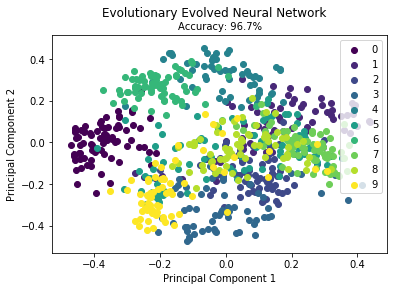

In [28]:
def main():

    X, y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=4, n_clusters_per_class=1, n_informative=2)

    data = datasets.load_digits()
    X = normalize(data.data)
    y = data.target
    y = to_categorical(y.astype("int"))

    # Model builder
    def model_builder(n_inputs, n_outputs):    
        model = NeuralNetwork(optimizer=Adam(), loss=CrossEntropy)
        model.add(Dense(16, input_shape=(n_inputs,)))
        model.add(Activation('relu'))
        model.add(Dense(n_outputs))
        model.add(Activation('softmax'))

        return model

    # Print the model summary of a individual in the population
    print ("")
    model_builder(n_inputs=X.shape[1], n_outputs=y.shape[1]).summary()

    population_size = 100
    n_generations = 3000
    mutation_rate = 0.01

    print ("Population Size: %d" % population_size)
    print ("Generations: %d" % n_generations)
    print ("Mutation Rate: %.2f" % mutation_rate)
    print ("")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, seed=1)

    model = Neuroevolution(population_size=population_size, 
                        mutation_rate=mutation_rate, 
                        model_builder=model_builder)
    
    model = model.evolve(X_train, y_train, n_generations=n_generations)

    loss, accuracy = model.test_on_batch(X_test, y_test)

    # Reduce dimension to 2D using PCA and plot the results
    y_pred = np.argmax(model.predict(X_test), axis=1)
    Plot().plot_in_2d(X_test, y_pred, title="Evolutionary Evolved Neural Network", accuracy=accuracy, legend_labels=range(y.shape[1]))


if __name__ == "__main__":
    main()